# Comparison of latent space models for the study of neural population dynamics

Code by: Pedro Herrero-Vidal
Created: 11/21/2020
Last updated: 12/13/2020

In [1]:
# Import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import math

from scipy import interpolate
import random

In [2]:
# local own implementations
%load_ext autoreload
%autoreload 2
from FRNN_wang_2006 import firing_rate_network, plot_NetworkAct_Input
from Bouroukan2017 import spiking
from plot_utils import plotNetwork_inputOutput, plotLSMtrajectories

# Data generation

## Low-dimensional latent: Initiate and simulate dynamics firing-rate model
Simulate firing-rate network with parameters $a=270Hz/nA, b=108Hz, d=.154s, \gamma=.64, \tau_s=.1s, g_E=.28nA, g_I=.047nA, g_{ext}=.00052nA, I_0=.3255nA$, $\tau_0=2ms$, noise amplitude $\sigma=.02$. We set initial conditions of $s_1=s_2=.1$.

In [3]:
network = firing_rate_network()

nTrials = 5
aS1, aS2, aR1, aR2, I1, I2, Td = network.simulation(I_1=10, I_2=0, I_12= 0, 
                                               t= 6, dt = 0.1/100,
                                               t1=.5, t2=1.5, t12=3.5, 
                                               pulse_t1=3,  pulse_t2=.8, pulse_t12=.75, 
                                               n_trial=nTrials)
bS1, bS2, bR1, bR2, I1, I2, Td = network.simulation(I_1=0, I_2=10, I_12= 0, 
                                               t= 6, dt = 0.1/100,
                                               t1=.5, t2=.5, t12=3.5, 
                                               pulse_t1=3,  pulse_t2=3, pulse_t12=.75, 
                                               n_trial=nTrials)
S1 = np.concatenate((aS1, bS1), axis=1)
S2 = np.concatenate((aS2, bS2), axis=1)
R1 = np.concatenate((aR1, bR1), axis=1)
R2 = np.concatenate((aR2, bR2), axis=1)
nTrials =10

plot_NetworkAct_Input(Td, I1, I2, R1, R2, S1, S2)

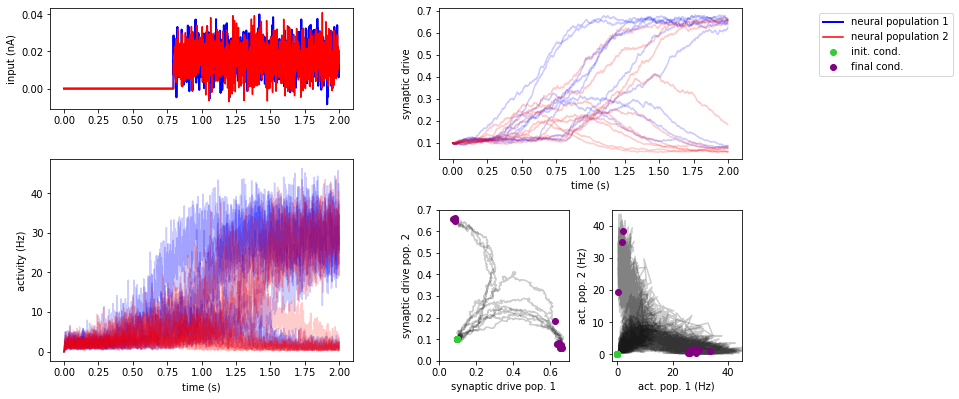

In [4]:
nTrials = 20
dta = 1e-3
tmax = 2
dtscaling = 10

S1a, S2a, R1, R2, I1, I2, Td = network.simulation(I_1=32, I_2=30, I_12= 0, 
                                               t= tmax, dt = dta, seed=27,
                                               onset_jitter=.23,
                                               t1=.5, t2=.5, t12=0, 
                                               sigma_I1 =15, sigma_I2 =15,
#                                                sigma= 0.005,
                                               pulse_t1=4,  pulse_t2=4, pulse_t12=0, 
                                               n_trial= int(nTrials/2) )
plot_NetworkAct_Input(Td, I1, I2, R1, R2, S1a, S2a)

S1b, S2b, R1, R2, I1, I2, Td = network.simulation(I_1=30, I_2=32, I_12= 0, 
                                               t= tmax, dt = dta, seed=27,
                                               onset_jitter=.23,
                                               t1=.5, t2=.5, t12=0, 
                                               sigma_I1 =15, sigma_I2 =15,
                                               pulse_t1=4,  pulse_t2=4, pulse_t12=0, 
                                               n_trial= int(nTrials/2) )

S1 = np.concatenate((S1a, S1b), axis=1)
S2 = np.concatenate((S2a, S2b), axis=1)
SC = np.concatenate((np.ones(int(nTrials/2)), np.ones(int(nTrials/2))+1))
Ds = S1[-1,:] > S2[-1, :]
CC = np.concatenate((np.array(S1a)[-1,:]>np.array(S2a)[-1,:], np.array(S1b)[-1,:]>np.array(S2b)[-1,:]))

add slow/fast process

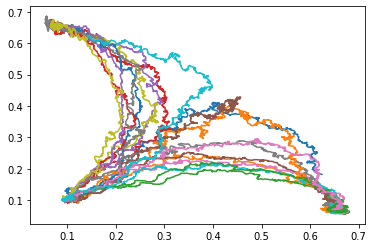

In [5]:
plt.figure()
plt.plot(S1, S2);

In [6]:
Ttrials = S1.shape[1]
S3 = np.zeros([S1.shape[0], Ttrials])
S3[0,:] = np.random.randn(Ttrials)*.01
for ss in range(Ttrials):
    #for tt in range(1, S1.shape[0]):
    #    S3[tt,ss] = .99*S3[tt-1,ss]+np.random.randn(1)*.01
    S3[:,ss] = np.sin(2*np.pi*np.linspace(0, 1, S3.shape[0]))
    S3[:,ss] = (S3[:,ss]-np.min(S3[:,ss]))/(np.max(S3[:,ss])-np.min(S3[:,ss]))*.7

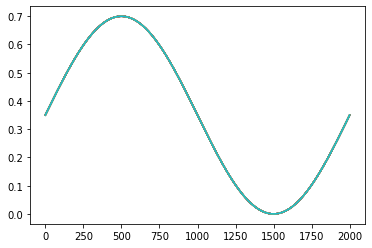

In [7]:
plt.figure()
plt.plot(S3);

In [8]:
#S3 = np.random.randn(2000,20)# stuff
#np.min(S3) = 0
#np.max(S3) = .7


## High-dimensional observations: generate spiking data from latents

In [9]:
## Signal scaling ([-10, 10])
cx = np.stack((S1, S2, S3))
# cx = np.stack((R1, R2))
# cs = ((( cx - 0. ) / ( 0.6 - 0. )) * ( 200. - (-200.) )) - 200.
cs = ((( cx - 0. ) / ( 0.6 - 0. )) * ( 10. - (-10.) )) - 10.

# Oversample by interpolation
zdim = cs.shape[0]
# dt = 1e-3
# dtsign = 10
# tmax = np.max(100)#*dtsign
dt = dta/dtscaling
timed = np.arange(0,tmax,dt)
n_step = len(timed)
# signscal = 10 # scal the signal in a +/- this value range to fit for the neuron
print(n_step)

newT = np.array(math.ceil(tmax/dt),dtype='int')
ma_x = np.zeros([zdim, newT, nTrials])
print(newT)

for ii in range(nTrials):
    f1 = interpolate.interp1d(np.arange(len(Td)), cs[0,:,ii], kind='cubic')
    f2 = interpolate.interp1d(np.arange(len(Td)), cs[1,:,ii], kind='cubic')
    f3 = interpolate.interp1d(np.arange(len(Td)), cs[2,:,ii], kind='cubic')

    xnew = np.linspace(0, np.max(len(Td))-1, n_step)# np.linspace(0, np.max(len(Td))-1, n_step)
    ma_x[:,:,ii] = np.array([f1(xnew), f2(xnew), f3(xnew)])

20000
20000


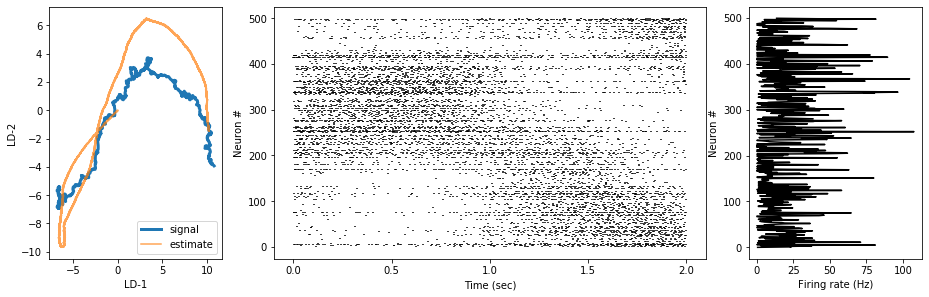

In [10]:
xdim = 500      # Number of neurons > 100 > 300 > 500
nu = .0133      # linear Spike Cost > 10-5 > .0001 > 0.012 > 0.0133
mu = .0008      # quadratic cost: distributing activity > 10-6 > .001 > 0.0008 >
lbd_d = 20# 20  # Readout Decay Rate, 1/time constant of the decoder >> set to 1 > 1/20 > set equal to lbd_v
lbd_v = 10#0.001  # 10 Membrane Leak, 1/time constant of the membrane > 1/10
decoderscaling = 20 #*scal/MOD.ydim*1000# **4 # 1* scal > to do >
thresh_nois_sig = 0.0029

np.random.seed(1)
SM = spiking()
SM.par(tmax, dt, timed, n_step, xdim, nu, mu, lbd_d, lbd_v, decoderscaling, J=zdim)

Omega, TT, D = SM.connect(Dtyp='hetero')
TT_noise = np.random.normal(0, .0035, TT.shape) # > .0008
TT += TT_noise
tt = 0
# X = np.zeros(ma_x.shape)*np.nan
c = np.zeros(ma_x.shape)*np.nan
_, c[:,:,tt] = SM.signal('LDS', ma_x[:,:,tt])
O, V, R, X_hat = SM.mixednet(c[:,:,tt], D, Omega, TT, seed=0, thresh_nois_sig=thresh_nois_sig)
# O, V, R, X_hat = SM.mixednet(ma_x[:,:,tt], D, Omega, TT, seed=0)#, thresh_nois_sig=0.0079)

plotNetwork_inputOutput(O, ma_x, X_hat, tmax, xdim, tt)

In [11]:
O.shape

(500, 20000)

## Data preprocessing: smoothing

In [12]:
bins = n_step/250 #.005 # binning
# dsamp = np.arange(0, n_step, bins)
dsamp = np.linspace(0, int(n_step-1), int(bins+1))
smthT = len(dsamp)-1
dtim = timed[dsamp.astype(int)]
dspikesT = np.zeros((xdim, smthT, nTrials))
print('Bin size: '+str(round((dsamp[1]-dsamp[0])/10))+'ms')

seedidx = 0
# optionally smooth through binning and averaging
for tt in range(nTrials):
#     tt=0
    Omega, TT, D = SM.connect(Dtyp='hetero') 
    TT += TT_noise # firing threshold variability across neurons
    _, c[:,:,tt] = SM.signal('LDS', ma_x[:,:,tt])
    O, V, R, X_hat = SM.mixednet(c[:,:,tt], D, Omega, TT, seed=seedidx, thresh_nois_sig=thresh_nois_sig) 
        # seed changes
    
    for ii in range(smthT):
        dspikesT[:,ii,seedidx] = np.sum(O[:,np.int(dsamp[ii]):np.int(dsamp[ii+1])], axis=1)
        
    seedidx +=1

Bin size: 25.0ms


In [13]:
sub_x = c[:, 1:n_step:int(n_step/smthT), :] # before ma_x

subN = 25# int(xdim) #100 # subset of population >>>

idxs = np.arange(O.shape[0])
np.random.shuffle(idxs)
ix = idxs[:subN] 

dspikesD = dspikesT[ix, :, :] # dspikesT[ix, :, CC] > select correct trials only
                              # nTrials = np.sum(CC)
                              # sub_x = np.array(sub_x[:, :, CC])
# dspikes = np.sqrt(dspikesD) ## square root spike transform 
# dspikesD = np.sqrt(dspikesT[ix, :, :])
dspikes = np.array(dspikesD)
xdim = dspikes.shape[0]
print('Using '+str(subN)+' neurons')

Using 25 neurons


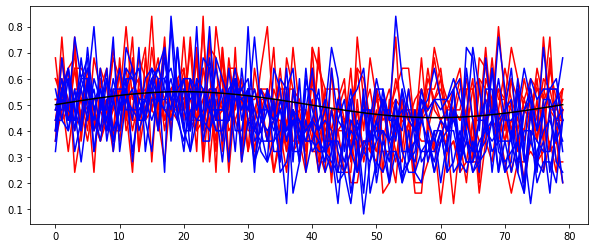

In [14]:
plt.figure(figsize=(10,4))
tmp = dspikesT[ix,:,:]
plt.plot(np.mean(tmp[:,:,SC==1], axis=0), '-r');
plt.plot(np.mean(tmp[:,:,SC==2], axis=0), '-b');
plt.plot(np.sin(2*np.pi*np.linspace(0, 1, dspikesT.shape[1]))*.05+.5, 'k')

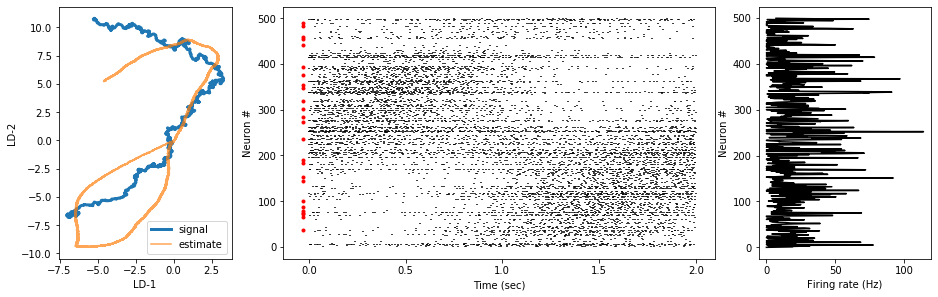

In [15]:
plotNetwork_inputOutput(O, ma_x, X_hat, tmax, xdim, tt, ix)

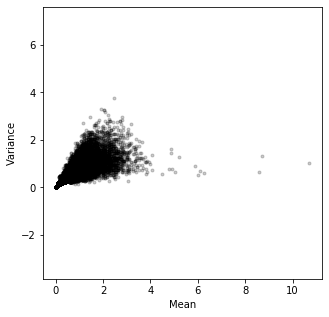

In [16]:
plt.figure(facecolor='w', figsize=(5, 5))
plt.plot(np.mean(dspikesT, axis=2), np.var(dspikesT,axis=2), 'k.', alpha=.2)
# plt.gca().set_aspect('equal')
# plt.axis('scaled')
plt.axis('equal')
plt.xlabel('Mean');
plt.ylabel('Variance');

# Static LSM: PCA/FA

In [17]:
from sklearn.decomposition import PCA

cosa = np.reshape(dspikes, (xdim, smthT, int(nTrials/2), 2), order='F')
cosa1 = np.mean(cosa, axis=2)
cosa2 = np.reshape(cosa1, (xdim, smthT*2), order='F')

In [18]:
# data preprocessing
X = dspikes.reshape((xdim, smthT* nTrials), order='F')
X = np.swapaxes(X, 0, 1)

# only works with balanced trials per condition
# X_stim = np.reshape(dspikes, (xdim, smthT, int(nTrials/2), 2), order='F') 
# X_stim_avg = np.reshape(np.mean(X_stim, axis=2), (xdim, smthT*2), order='F')
# # X_stim_avg = np.mean(dspikes, 2)
# X_avg = np.swapaxes(X_stim_avg, 0, 1)

X_stim_avg = []
for jj in np.unique(SC):
    temp_mask = SC == jj
#     temp_mask = SC[CC] == jj
    X_stim_avg.append(np.mean(dspikes[:, :, temp_mask], axis=2))
    
X_avg = np.swapaxes(np.concatenate(X_stim_avg, axis=1), 0, 1)

In [19]:
# tria-avg + single trials PCA
pca_dim = 2
pca = PCA(n_components=xdim)
pca.fit(X_avg)
Z_PCA = pca.transform(X)
a = np.swapaxes(Z_PCA[:, :pca_dim], 0, -1)
b_PCA = np.reshape(a, (pca_dim, smthT, nTrials), order='F') # all trials in PC space

# tria-concatenated PCA
# pca_dim = 2
# pca = PCA(n_components=pca_dim)
# pca.fit(X)
# Z_PCA = pca.transform(X)
# a = np.swapaxes(Z_PCA[:, :pca_dim], 0, -1)
# b_PCA = np.reshape(a, (pca_dim, smthT, nTrials), order='F') # all trials in PC space

# trial-avg. PCA
pca_avg = PCA(n_components=pca_dim)
pca_avg.fit(X_avg)
Z_PCAavg = np.reshape(pca_avg.transform(X_avg), (smthT, 2, pca_dim), order='F') # time x trials (stim) x LD 
Z_PCAavg = np.swapaxes(np.swapaxes(Z_PCAavg, 0,1), 0,2) # LD x time x trials (stim)
# Z_PCAavg = np.swapaxes(pca_avg.transform(X_avg), 0, 1)
# Z_PCAavg = np.swapaxes(np.swapaxes([Z_PCAavg for i in range(nTrials)], 0,1), 1,2)

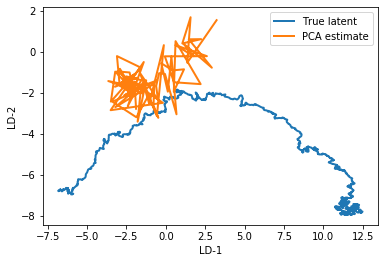

In [20]:
kk = 1
plt.plot(ma_x[0,:,kk], ma_x[1,:,kk], lw=2)
plt.plot(b_PCA[0,:,kk], b_PCA[1,:,kk], lw=2);
plt.xlabel('LD-1')
plt.ylabel('LD-2')
plt.legend(['True latent', 'PCA estimate']);

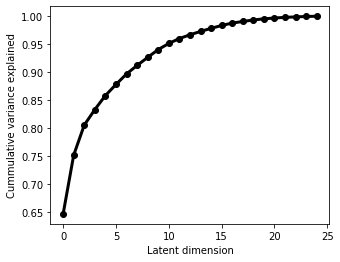

In [21]:
plt.figure(figsize=(5,4), facecolor='w')
plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o', lw=3, c='k')
plt.xlabel('Latent dimension')
plt.ylabel('Cummulative variance explained');
# plt.vlines(2, 0.52, 1, linestyles='--', colors='#1f77b4');

In [22]:
%load_ext autoreload
%autoreload 2
from sklearn.decomposition import FactorAnalysis
from FA_utils import FA_EM, FA_project, FA_LNOCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# FA
X_mu = np.mean(X_avg.T, axis=1);          # data mean                # np.mean(X.T, axis=1); 
X_cov = np.cov(X_avg.T)                   # data covariance          # np.cov(X.T)
xDim = len(X_mu);                         # observation space dimensions
if np.linalg.det(X_cov) < 1e-7:
    print('Warning! The determinant of the covariance matrix is quite low')
if np.linalg.matrix_rank(X.T) < X.shape[1]:
    print('Warning! Data matrix is not full rank')

zDims = np.arange(15)+1                 # latent space dimensions to test
eps = 1e-5                              # define stopping value
LL_dim = []                             # max LL per dim

Cs = []
Rs = []
LL_cache = []
FA_PE = []
FA_PE_sklern = []
X_faReconstruct = []
faerror = []

for zDim in zDims:
#     print(zDim)
    tC, tR, tLL_cache, _ = FA_EM(X_cov, xDim, zDim, eps, X.shape[0])
    foo_err, Xii = FA_LNOCV(tC, tR, np.swapaxes(X, 0,1))
    FA_PE.append(foo_err)
    X_faReconstruct.append(Xii)
    Cs.append(tC)
    Rs.append(tR)
    LL_cache.append(tLL_cache)
    
    fa = FactorAnalysis(n_components=zDim)
    fa.fit_transform(X);
    FA_PE_sklern.append(FA_LNOCV(fa.components_.T, np.diag(fa.noise_variance_), np.swapaxes(X, 0,1))[0])    

Warning! The determinant of the covariance matrix is quite low


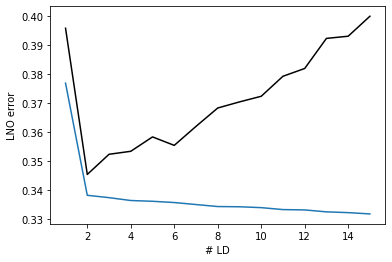

In [24]:
plt.plot(zDims, FA_PE, 'k')
plt.plot(zDims, FA_PE_sklern)
plt.ylabel('LNO error')
# plt.ylim([0, 10])
plt.xlabel('# LD');

In [25]:
#  choose a dimension for visualization
rzDim = 1 # there is a 2 dimensional offset
Re = Rs[rzDim]
Ce = Cs[rzDim]
Z_FA = FA_project(Ce, Re, X, X_mu)
b_FA = np.reshape(Z_FA, (zDims[rzDim], smthT, nTrials), order='F') # trials in latent space

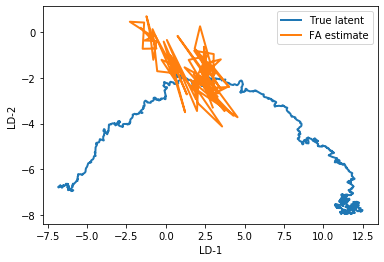

In [26]:
plt.plot(ma_x[0,:,kk], ma_x[1,:,kk], lw=2)
plt.plot(b_FA[0, :,kk], b_FA[1, :,kk], lw=2);
plt.xlabel('LD-1'); plt.ylabel('LD-2'); plt.legend(['True latent', 'FA estimate']);

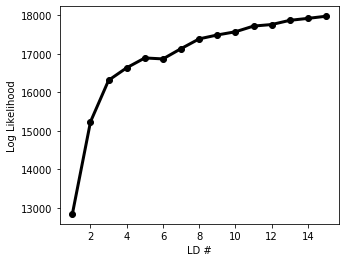

In [27]:
plt.figure(figsize=(5,4), facecolor='w')
plt.plot(zDims, np.array([i[-1] for i in LL_cache]), '-o', c='k', lw=3)
plt.xlabel('LD #')
plt.ylabel('Log Likelihood');
# plt.vlines(2, -190000, -172500, linestyles='--', colors='darkorange');

# Dynamic LSM: P-KF/LDS

In [28]:
%load_ext autoreload
%autoreload 2
from PLDS_Macke2015 import EM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


IndentationError: expected an indented block (PLDS_Macke2015.py, line 424)

In [ ]:
dataX = np.swapaxes(dspikesD, 0, 1) # time x obs_dim x trials

In [ ]:
plt.figure(facecolor='w')
plt.plot(np.mean(dspikes, axis=2), np.var(dspikes,axis=2), '.')
plt.xlabel('Mean');
plt.ylabel('Variance');

In [ ]:
fit = EM(maxiter=100, gtol=1e-05)
Poisson = True
# expect data to be T by ydim by Trials
MOD0 = fit.fit(data=dataX, xdim=zdim, poisson=Poisson, seed=0, S=None, 
               maxiterem=5, cscal=.1, sigQ = 0.001 , a=.1, sigR=.1)[0]

In [ ]:
Z_LDS, _ = MOD0.E_step(MOD0.x, dataX, MOD0.B, MOD0.C, MOD0.A, MOD0.Q, MOD0.Q0, MOD0.x0, MOD0.R, poisson=Poisson);
#Z_LDS = np.swapaxes(Z_LDS, 0,1)

# Dynamic LSM: P-GPFA

In [34]:
%load_ext autoreload
%autoreload 2
import funs.util as util
import funs.engine as engine

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# Initialize random number generator
np.random.seed(123)

data = []
for ii in range(nTrials):
    temp_dict = {}
    temp_dict['Y'] = dspikesD[:,:,ii]
    data.append(temp_dict)

# dataset = {}
# dataset['data'] = data
# dataset['T'] = smthT
trialDur = tmax * 1000 # in ms
binSize = int(trialDur/bins) 
dOffset = 1
n_dim_state = 2

training_set  = util.dataset(seed      = np.random.randint(10000),
                             xdim      = n_dim_state,
                             ydim      = xdim,
                             numTrials = nTrials,
                             trialDur  = trialDur,
                             binSize   = binSize,
                             dOffset   = dOffset,
                             fixTau    = True, 
                             fixedTau  = np.linspace(0.1,.5,xdim), # np.linspace(0.1,.5,xdim),
                             drawSameX = True)

training_set.data = data
initParams = util.initializeParams(n_dim_state, xdim, training_set)

+------------- Simulated Dataset Options -------------+
                                                    2 | Dimensionality of Latent State
                                                   25 | Dimensionality of Observed State (# neurons)
                                                 2000 | Duration of trials (ms):
                                                   25 | Size of bins (ms):
                                                   20 | Number of Trials
+-----------------------------------------------------+
Sampling trial 20 ...
Average firing rate per neuron in this dataset: 36.583 Hz.
Initializing parameters with Poisson-PCA..


In [36]:
fitBatch = engine.PPGPFAfit(experiment       = training_set,
                            initParams       = initParams,
                            inferenceMethod  = 'laplace',
                            EMmode           = 'Batch',
                            maxEMiter        = 20,
                            getPredictionErr = True)

+-------------------- Fit Options --------------------+
                                                    2 | Dimensionality of Latent State
                                                   25 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                   20 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration:  20 of  20, nPLL: = -920.55272
This dataset is a simulated dataset.
Processing performance against ground truth parameters...
Performing leave-one-out cross validation...


In [37]:
Z_meanGP = np.array(fitBatch.infRes['post_mean'])
Z_meanGP1 = np.swapaxes(Z_meanGP, 0,1)
Z_GP = np.swapaxes(Z_meanGP1, 1,2)

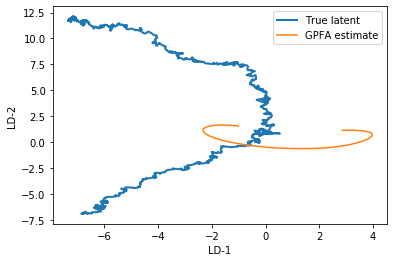

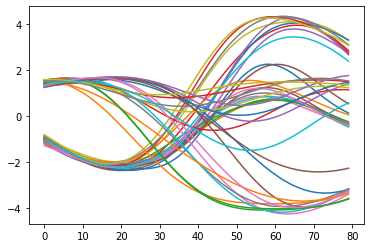

In [38]:
ttt =3
plt.plot(ma_x[0,:,ttt], ma_x[1,:,ttt], lw=2)
plt.plot(Z_GP[0,:,ttt], Z_GP[1,:,ttt])
plt.xlabel('LD-1'); plt.ylabel('LD-2'); plt.legend(['True latent', 'GPFA estimate']);

plt.figure()
plt.plot(Z_GP[0,:,:]);
plt.plot(Z_GP[1,:,:]);

# Visual inspection of latent trajectories

In [39]:
print(sub_x.shape)
print(b_PCA.shape)
print(Z_PCAavg.shape)
print(b_FA.shape)
print(Z_LDS.shape)
print(Z_GP.shape)

(3, 80, 20)
(2, 80, 20)
(2, 80, 2)
(2, 80, 20)
(80, 3, 20)
(2, 80, 20)


In [40]:
from scipy.linalg import orthogonal_procrustes
def rotate_latent(sub_x, b_latent):
    cSub_x = sub_x.reshape(sub_x.shape[0], sub_x.shape[1] * sub_x.shape[2], order='F')
    c_latent  = b_latent.reshape(b_latent.shape[0], b_latent.shape[1] * b_latent.shape[2], order='F')
    
    R, _ = orthogonal_procrustes(c_latent, cSub_x)
    return np.reshape(np.dot(c_latent, R), (b_latent.shape[0], b_latent.shape[1], b_latent.shape[2]), order='F')

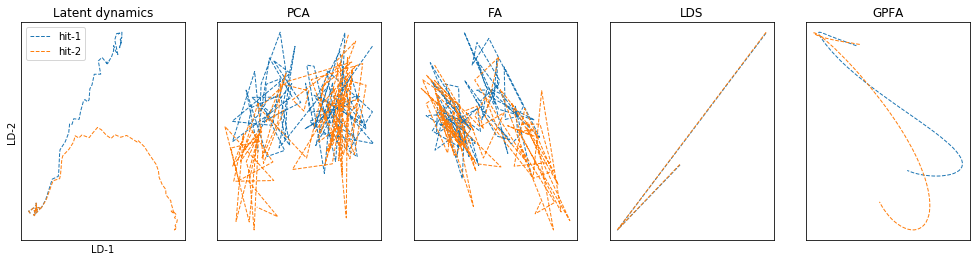

In [41]:
plotLSMtrajectories(sub_x, b_PCA, b_FA, Z_LDS, Z_GP, 
                    np.array(SC-1, dtype=bool), cc_off=0, legnd = ['hit-1', 'hit-2'])

In [39]:
oZ_PCA  = rotate_latent(sub_x[:2,:,:], b_PCA)
oZ_FA   = rotate_latent(sub_x[:2,:,:], b_FA)
oZ_LDS  = rotate_latent(sub_x[:2,:,:], Z_LDS[:2,:,:])
oZ_GPFA = rotate_latent(sub_x[:2,:,:], Z_GP)

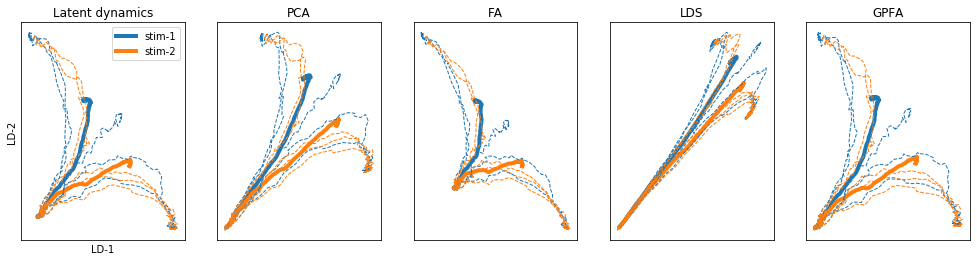

In [40]:
plotLSMtrajectories(sub_x, oZ_PCA, oZ_FA, oZ_LDS, oZ_GPFA, 
                    np.array(SC-1, dtype=bool), cc_off=0, legnd = ['stim-1', 'stim-2'])

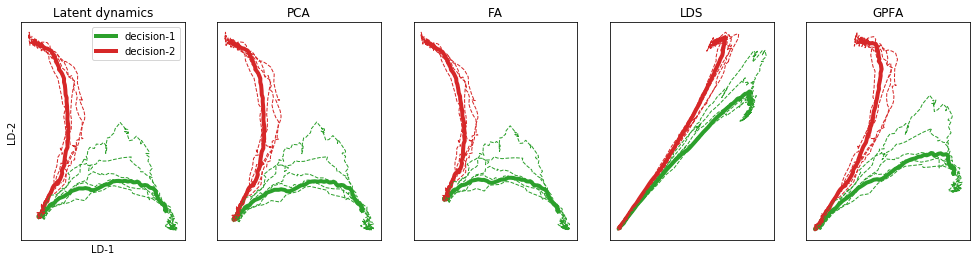

In [85]:
plotLSMtrajectories(sub_x, oZ_PCA, oZ_FA, oZ_LDS, oZ_GPFA, 
                    Ds, cc_off=2, legnd = ['decision-1', 'decision-2'])

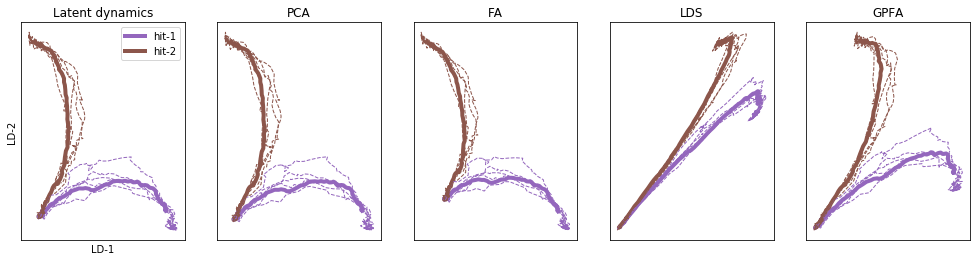

In [86]:
plotLSMtrajectories(sub_x, oZ_PCA, oZ_FA, oZ_LDS, oZ_GPFA, 
                    CC, cc_off=4, legnd = ['hit-1', 'hit-2'])

## loading matrices

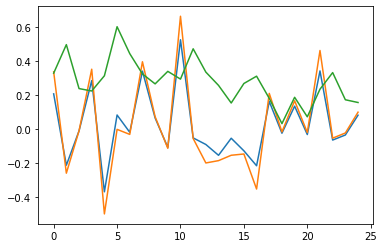

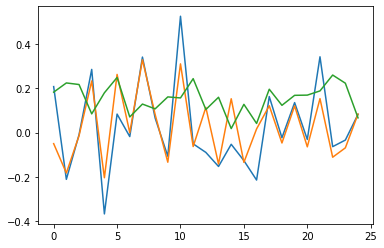

In [90]:
plt.figure()
dim = 0
plt.plot(pca.components_[0,:].T);
rzDim = list(zDims).index(2)
plt.plot(-Cs[rzDim][:,dim])
plt.plot(MOD0.C[:,dim].T*10);
#plt.plot(D[dim,:])

plt.figure()
dim = 1
plt.plot(pca.components_[0,:].T);
rzDim = list(zDims).index(2)
plt.plot(-Cs[rzDim][:,dim])
plt.plot(MOD0.C[:,dim].T*10);

In [88]:
D.shape

(3, 500)